In [1]:
import os

# import efficientnet.tfkeras as efn
import pandas as pd
import numpy as np
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.applications.efficientnet as efn

In [2]:
auto_select_accelerator()

build_decoder(with_labels=True, target_size=(256, 256), ext='jpg')

build_augmenter(with_labels=True)

build_dataset(paths, labels=None, bsize=32, cache=True,
              decode_fn=None, augment_fn=None,
              augment=True, repeat=True, shuffle=1024, 
              cache_dir="")

NameError: name 'auto_select_accelerator' is not defined

In [3]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy

def build_decoder(with_labels=True, target_size=(300, 300), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment

def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

In [4]:
COMPETITION_NAME = "ranzcr-clip-catheter-line-classification"
strategy = auto_select_accelerator()
BATCH_SIZE = 10
# GCS_DS_PATH = KaggleDatasets().get_gcs_path(COMPETITION_NAME)

Running on 1 replicas


In [5]:
load_dir = f"/kaggle/input/{COMPETITION_NAME}/"
df = pd.read_csv(load_dir + 'train.csv')
paths = load_dir + "train/" + df['StudyInstanceUID'] + '.jpg'

sub_df = pd.read_csv(load_dir + 'sample_submission.csv')
test_paths = load_dir + "test/" + sub_df['StudyInstanceUID'] + '.jpg'

# Get the multi-labels
label_cols = sub_df.columns[1:]
labels = df[label_cols].values

In [6]:
# Train test split
(
    train_paths, valid_paths, 
    train_labels, valid_labels
) = train_test_split(paths, labels, test_size=0.2, random_state=42)

In [7]:
# Build the tensorflow datasets
IMSIZES = (224, 240, 260, 300, 380, 456, 528, 600)
# index i corresponds to b-i
size = IMSIZES[2]

decoder = build_decoder(with_labels=True, target_size=(size, size))
test_decoder = build_decoder(with_labels=False, target_size=(size, size))

# Build the tensorflow datasets
dtrain = build_dataset(
    train_paths, train_labels, bsize=BATCH_SIZE, 
    cache_dir='/kaggle/tf_cache', decode_fn=decoder
)
dvalid = build_dataset(
    valid_paths, valid_labels, bsize=BATCH_SIZE, 
    repeat=False, shuffle=False, augment=False, 
    cache_dir='/kaggle/tf_cache', decode_fn=decoder
)

dtest = build_dataset(
    test_paths, bsize=BATCH_SIZE, repeat=False, 
    shuffle=False, augment=False, cache=False, 
    decode_fn=test_decoder
)

In [8]:
model_path = '../input/tfkeras-efficientnet-weights/efficientnetb2_notop.h5'  # imagenet
n_labels = labels.shape[1]

with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB2(
            input_shape=(size, size, 3),
            weights=model_path,
            include_top=False,
            drop_connect_rate=0.5),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(n_labels, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(multi_label=True)])
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 9, 9, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                15499     
Total params: 7,784,068
Trainable params: 7,716,493
Non-trainable params: 67,575
_________________________________________________________________


In [9]:
# ############### Train the model ###############
steps_per_epoch = train_paths.shape[0] // BATCH_SIZE
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model.h5', save_best_only=True, monitor='val_auc', mode='max')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_auc", patience=3, min_lr=1e-6, mode='max')

In [10]:
history = model.fit(
    dtrain, 
    epochs=20,
    verbose=1,
    callbacks=[checkpoint, lr_reducer],
    steps_per_epoch=steps_per_epoch,
    validation_data=dvalid)

Epoch 1/20
2406/2406 [==============================] - 2111s 838ms/step - loss: 0.2619 - auc: 0.7175 - val_loss: 0.4946 - val_auc: 0.5010
Epoch 2/20
2406/2406 [==============================] - 460s 191ms/step - loss: 0.2215 - auc: 0.7937 - val_loss: 1.2301 - val_auc: 0.5055
Epoch 3/20
2406/2406 [==============================] - 461s 191ms/step - loss: 0.2112 - auc: 0.8147 - val_loss: 0.4761 - val_auc: 0.5292
Epoch 4/20
2406/2406 [==============================] - 468s 195ms/step - loss: 0.2020 - auc: 0.8425 - val_loss: 0.3896 - val_auc: 0.5189
Epoch 5/20
2406/2406 [==============================] - 463s 192ms/step - loss: 0.1948 - auc: 0.8595 - val_loss: 0.4569 - val_auc: 0.5096
Epoch 6/20
2406/2406 [==============================] - 463s 193ms/step - loss: 0.1892 - auc: 0.8677 - val_loss: 0.5661 - val_auc: 0.5659
Epoch 7/20
2406/2406 [==============================] - 463s 192ms/step - loss: 0.1846 - auc: 0.8770 - val_loss: 0.4518 - val_auc: 0.4800
Epoch 8/20
2406/2406 [===========

In [11]:
model.load_weights('model.h5')

In [12]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')


In [13]:
sub_df[label_cols] = model.predict(dtest, verbose=1)
sub_df.to_csv('submission.csv', index=False)

sub_df.head()

359/359 [==============================] - 280s 773ms/step


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0.002774,0.247924,0.692558,0.008074,0.008186,0.012950,0.933195,0.011589,0.305120,0.983495,0.999777
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0.000008,0.000058,0.000188,0.000103,0.000156,0.000029,0.000770,0.035739,0.009350,0.978251,0.000011
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0.000008,0.000017,0.000034,0.000416,0.000160,0.000079,0.000016,0.019678,0.224111,0.806698,0.000042
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0.014100,0.014168,0.006583,0.042850,0.043270,0.859724,0.049405,0.338701,0.180411,0.687646,0.026714
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0.000048,0.000128,0.000049,0.001248,0.001826,0.000017,0.003213,0.011294,0.080163,0.955352,0.000006


In [14]:
 from matplotlib import pyplot as plt 

KeyError: 'auc_1'

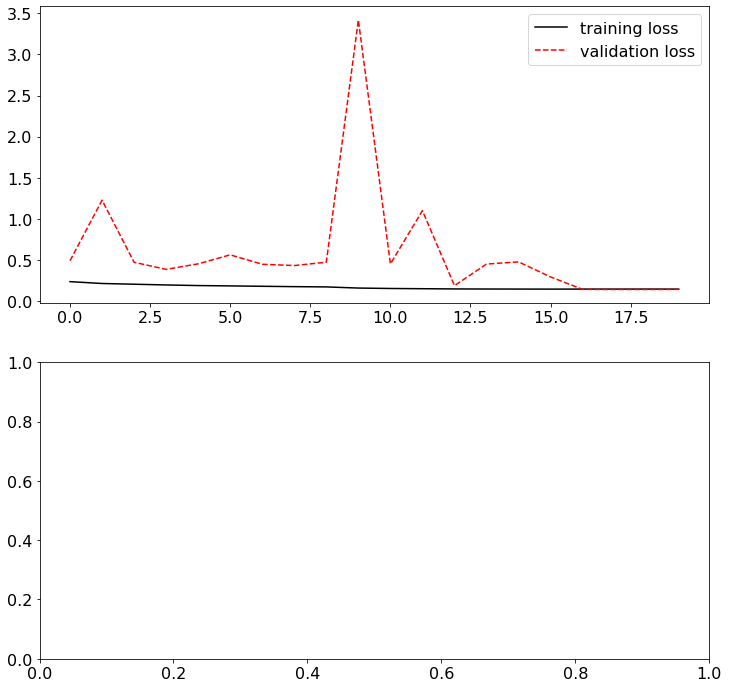

In [15]:
plt.rcParams.update({'font.size': 16})
hist = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(figsize=(12,12),nrows=2, ncols=1)
hist['loss'].plot(ax=ax1,c='k',label='training loss')
hist['val_loss'].plot(ax=ax1,c='r',linestyle='--', label='validation loss')
ax1.legend()
hist['auc_1'].plot(ax=ax2,c='k',label='training AUC')
hist['val_auc_1'].plot(ax=ax2,c='r',linestyle='--',label='validation AUC')
ax2.legend()
plt.show()